#  <center>Xilinx暑期学校作业-filter2d</center>

## 组员：
&emsp;&emsp;（1）华东师范大学软件学院-荣嘉祺<br>
&emsp;&emsp;（2）华东师范大学软件学院-曹淇俊

## 实验前瞻

&emsp;&emsp;filter2d我觉得和lab2的那个Sobel算子的做法是几乎一模一样的：C++代码上只需要修改下sobel.cpp中对于卷积核那部分的处理即可，添加一个kernel输入后，通过for循环来将九个位子上的数值相乘后即可返回结果；而之后的硬件处理上也和之前的lab2中的大同小异，整体来说难度较为简单。

## 实验执行

&emsp;&emsp;首先先读取txt中的数据数据，其读到的数据先转为int后，类型转变为列表：

In [1]:
with open("../src/src.txt", "r") as f:
    x = list(map(int, f.readlines()))
with open("../src/dst.txt", "r") as f:
    y = list(map(int, f.readlines()))

&emsp;&emsp;将读取到的一维数据改为二维数据，其中image_in为卷积前的图像数据，image_out为卷积后的图像数据：

In [5]:
import numpy as np
image_in = np.array(x, dtype=np.uint8).reshape(128, 128)
image_out = np.array(y).reshape(126, 126)
image_in, image_out

(array([[205, 204, 205, ..., 247, 247, 246],
        [205, 205, 204, ..., 248, 248, 248],
        [205, 205, 205, ..., 248, 247, 247],
        ...,
        [161, 164, 151, ..., 102, 102, 109],
        [174, 168, 173, ..., 119, 139,  93],
        [161, 156, 168, ..., 114, 119, 134]], dtype=uint8),
 array([[  2,   2,  -2, ...,   1,   2,   2],
        [  1,   3,   2, ...,  -1,  -3,  -4],
        [  4,  12,  20, ...,  -1,  -2,  -1],
        ...,
        [-42, -27,  19, ..., -45, -63, -80],
        [ 13, -10, -35, ..., -37,   1,  21],
        [  1,  28,  11, ...,  -5,  28,  71]]))

&emsp;&emsp;接下来使用matplotlib对图像进行显示，首先是输入图片（前半部分的代码内容执行我是在电脑上完成的，所以这里一开始打算是用opencv显示的，因为比较熟，那样的话图片就是以弹窗的形式出来的，但是后来发现dst中的图片数据中有负值，然而一开始image_out我的读取方法是uint8，结果导致图片中出现了很多噪声，去掉之后直接使用cv2.imshow显示会出问题，所以干脆就用matplotlib来显示了，主要也是因为我的matplotlib在使用的时候会报一些版本号的警告，看起来就很红，所以一开始并不是很想用这个）


Bad key text.latex.preview in file D:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file D:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file D:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to get an updated matplotli

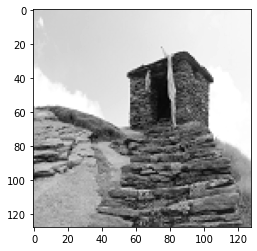

In [6]:
from matplotlib import pyplot as plt
plt.imshow(image_in, cmap='gray')

&emsp;&emsp;接下来通过matplotlib来显示输出图像

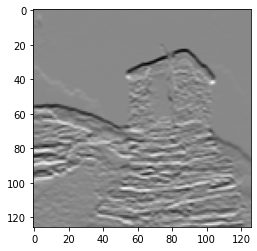

In [9]:
plt.imshow(image_out, cmap='gray')

&emsp;&emsp;接下来用opencv中自带的Sobel算子来对图像进行处理，并计算对应的生成时间：

Need Time: 0.0s
Need Time: 0.0009622573852539062s


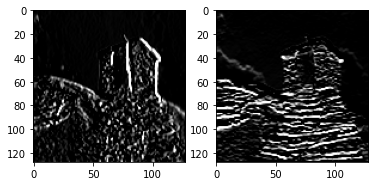

In [13]:
import cv2
import time

start_time1 = time.time()
sobel_x = cv2.Sobel(image_in,cv2.CV_8U,1,0)
end_time1 = time.time()

print("Need Time: {}s".format(end_time1-start_time1))

start_time2 = time.time()
sobel_y = cv2.Sobel(image_in,cv2.CV_8U,0,1)
end_time2 = time.time()

print("Need Time: {}s".format(end_time2-start_time2))

fig_sobel = plt.figure()
fig_sobel.add_subplot(121)
plt.imshow(sobel_x, cmap='gray')
fig_sobel.add_subplot(122)
plt.imshow(sobel_y, cmap='gray')

&emsp;&emsp;接下来导入bit文件：

In [8]:
from pynq import Overlay
overlay = Overlay("../overlay/filter2d.bit")

&emsp;&emsp;接下来的步骤就和lab2中的步骤相似了：

In [9]:
filter2d = overlay.filter2d_accel_0

In [10]:
filter2d.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  img_in = Register(img_in=write-only),
  kernel = Register(kernel=write-only),
  img_out = Register(img_out=write-only),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

In [11]:
from pynq import allocate
img_in_buffer = allocate(shape=(len(x),), dtype='i4')
img_out_buffer = allocate(shape=(len(y),), dtype='i4')
kernel1_buffer = allocate(shape=(3*3,), dtype='i4')
kernel2_buffer = allocate(shape=(3*3,), dtype='i4')

&emsp;&emsp;创造两个kernel，分别是sobel在x和y轴方向上的卷积核：

In [12]:
np.copyto(img_in_buffer, np.int16(x))

np.copyto(kernel1_buffer, np.int16([-1, 0, 1, 
                                   -2, 0, 2, 
                                   -1, 0, 1]))


np.copyto(kernel2_buffer, np.int16([-1, -2, -1, 
                                   0,  0,  0, 
                                   1,  2,  1]))

In [13]:
filter2d.write(0x10, img_in_buffer.physical_address)
filter2d.write(0x20, img_out_buffer.physical_address)
filter2d.write(0x28, 128)
filter2d.write(0x30, 128)

HW Time：0.0014922618865966797s
HW Time：0.0008516311645507812s


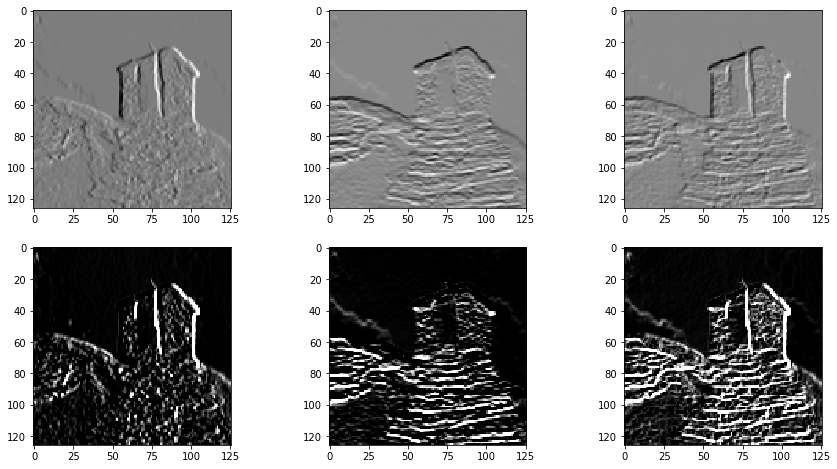

In [17]:
import time

filter2d.write(0x18, kernel1_buffer.physical_address)
filter2d.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = filter2d.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("HW Time：{}s".format(end_time - start_time))

img_out_x = np.int16(img_out_buffer)

filter2d.write(0x18, kernel2_buffer.physical_address)
filter2d.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = filter2d.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("HW Time：{}s".format(end_time - start_time))

img_out_y = np.int16(img_out_buffer)

fig_img_out = plt.figure()
fig_img_out.set_figheight(8)
fig_img_out.set_figwidth(15)
fig_img_out.add_subplot(231)
plt.imshow(img_out_x.reshape(126, 126), cmap='gray')
fig_img_out.add_subplot(232)
plt.imshow(img_out_y.reshape(126, 126), cmap='gray')
fig_img_out.add_subplot(233)
plt.imshow(img_out_y.reshape(126, 126) + img_out_x.reshape(126, 126), cmap='gray')
fig_img_out.add_subplot(234)
plt.imshow(np.clip(img_out_x.reshape(126, 126), 0, 255), cmap='gray')
fig_img_out.add_subplot(235)
plt.imshow(np.clip(img_out_y.reshape(126, 126), 0, 255), cmap='gray')
fig_img_out.add_subplot(236)
plt.imshow(np.clip(np.clip(img_out_x.reshape(126, 126), 0, 255) + np.clip(img_out_y.reshape(126, 126), 0, 255), 0, 255), cmap='gray')

## 实验小结

&emsp;&emsp;本次暑期学校我觉得整体节奏还是蛮不错的，lab1和lab2的实验指导pdf写的也非常的详细，就是lab2的那个文档里面开头初始化的时候忘记写了个top function该选哪个，其他的没啥问题。老师上课的时候也很认真负责，对于我们解答的问题也很认真的进行了回答，印象很深的是有一次课的上课时间是1个小时，结果回答问题的时间都快赶上上课的时间了。<\br>
&emsp;&emsp;整体的课程内容还是比较紧凑的，因为我之前对于这个其实没有什么了解，但通过这次课程，对pynq的整体框架和执行流程有了一定的认识和了解，同时作为助教，在给各个同学提供帮助的同时，也锻炼了我的团队分工能力等。总的来说这次暑期学校给我带来了一次较好的学习体验，谢谢各位老师，辛苦了。